In [1]:
import pandas as pd
import numpy as np

In [20]:
data = pd.read_csv('../data/new_test_data.csv')

In [21]:
data

occurrence  0  1  2  3  4  5  6  7  8  ... 30 31 32 33 34 35 36 37 38 39
0             0  A  G  T  G  A  T  G  A  T  ...  T  G  G  A  T  G  A  T  G  C
1             0  A  G  T  G  A  T  G  A  T  ...  G  T  A  G  C  G  T  G  G  T
2             0  A  G  T  G  A  T  G  A  T  ...  T  G  T  G  G  C  A  G  G  A
3             0  A  G  T  G  A  T  G  A  T  ...  T  A  G  G  G  C  G  G  T  G
4             0  A  G  T  G  A  T  G  A  T  ...  G  T  G  G  T  A  G  G  C  T
..          ... .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
788           1  A  G  G  G  T  T  G  G  T  ...  T  G  T  G  G  T  A  G  G  C
789           1  A  G  G  G  T  T  G  G  T  ...  T  G  T  G  G  T  A  G  G  C
790           1  A  G  G  G  T  T  G  G  T  ...  T  G  T  G  G  T  T  G  G  C
791           1  A  G  G  G  T  T  G  G  T  ...  T  G  T  G  G  T  T  G  G  C
792           1  A  G  G  G  T  T  G  G  T  ...  T  G  T  G  G  T  A  G  G  C

[793 rows x 41 columns]

In [22]:
# https://sparkbyexamples.com/pandas/how-to-count-duplicates-in-pandas-dataframe/
data.pivot_table(index = ['occurrence'], aggfunc ='size')

occurrence
0     64
1    729
dtype: int64

In [23]:
#data = data[:128]
#data.pivot_table(index = ['occurrence'], aggfunc ='size')

In [24]:
data.duplicated(keep='first').sum()

0

In [25]:
matrix = [[[0] * 40 for i in range(4)] for n in range(len(data))]
print(np.array(matrix).shape)

(793, 4, 40)


In [26]:
data.reset_index(inplace=True)

for index, row in data.iterrows():
    x = 0
    for i in row:
        if (i == 'A'):
            matrix[index][0][x] = 1
        elif (i == 'C'):
            matrix[index][1][x] = 1
        elif (i == 'G'):
            matrix[index][2][x] = 1
        elif (i == 'T'):
            matrix[index][3][x] = 1
        else:
            continue
        x += 1

In [27]:
print(matrix[0])

[[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]]


In [28]:
import torch
import torch.utils.data as data_utils
test_y = torch.tensor(data.occurrence.values.astype(np.longlong))
test_x = torch.tensor(np.array(matrix).astype(np.float32).transpose(0, 2, 1)) 
test_tensor = data_utils.TensorDataset(test_x, test_y) 
testloader = data_utils.DataLoader(dataset = test_tensor, batch_size = 128)

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
class BiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(4, 32, 3, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(32 * 2, 64)
        self.fco = nn.Linear(64, 2)

    def forward(self, x):
        #print(x.shape)
        lstm_out, (hn, cn) = self.lstm(x)
        x = F.relu(self.fc1(lstm_out[:, -1, :]))
        x = self.fco(x)
        return x

In [30]:
loaded_model = torch.compile(BiLSTM())
loaded_model.load_state_dict(torch.load('../lstm/dupes-32-3-sgd-64.pt'))
loaded_model.eval()

OptimizedModule(
  (_orig_mod): BiLSTM(
    (lstm): LSTM(4, 32, num_layers=3, batch_first=True, bidirectional=True)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fco): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [31]:
loss_fn = torch.nn.CrossEntropyLoss()

In [32]:
test_predictions = np.zeros(len(data.occurrence))
test_y = np.zeros(len(matrix))
print(test_predictions.shape)
ii = 0
for vdata in testloader:
    vinputs, vlabels = vdata
    with torch.no_grad():
        voutputs = loaded_model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
    test_predictions[ii:(ii + vinputs.shape[0])] = voutputs.argmax(1).numpy()
    test_y[ii:(ii + vinputs.shape[0])] = vlabels.numpy()
    ii += vinputs.shape[0]

(793,)


In [33]:
from sklearn.metrics import accuracy_score
print(f"Testovací přesnost: {accuracy_score(test_y, test_predictions)}")

Testovací přesnost: 0.8726355611601513


In [34]:
from sklearn import metrics
matr = metrics.confusion_matrix(test_y, test_predictions)
matr

array([[ 16,  48],
       [ 53, 676]])

In [35]:
metrics.f1_score(1-test_y, 1-test_predictions)

0.24060150375939848

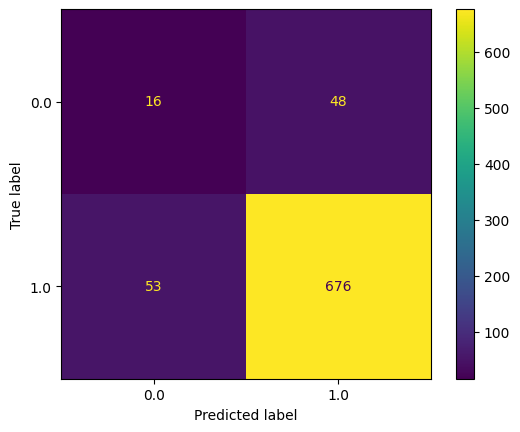

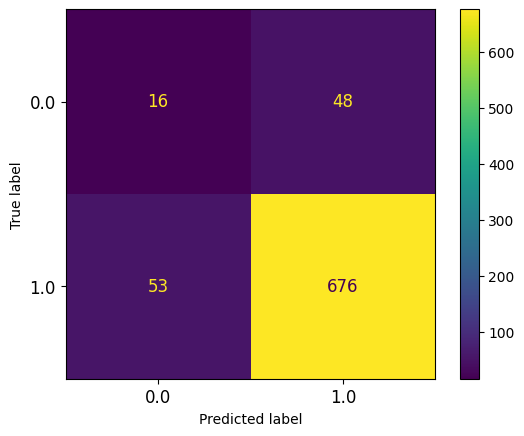

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already imported necessary modules and defined data and prediction

# Generate the confusion matrix display
disp = ConfusionMatrixDisplay.from_predictions(test_y, test_predictions)

fig, ax = plt.subplots()

disp.plot(ax=ax)

# Increase font size of values inside the matrix
for i in range(len(disp.text_)):
    for j in range(len(disp.text_[0])):
        disp.text_[i][j].set_fontsize(12)

# Set font size for tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

In [19]:
test_predictions

array([1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])